In [1]:
import ae
import tensorflow as tf
import os
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from audioop import rms
from matplotlib.pyplot import ylabel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2022-11-14 05:04:21.327348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 05:04:21.543207: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 05:04:22.607327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:/home/can/thesis_ws/devel/lib:/home/can/bfmc_ws/devel/lib:/opt/ros/noetic/lib
2022-11-14 05:04:22.607459: W tensorflow/stream_executor/platform/default/dso_loader.

In [2]:
def testset(test_path, model, dmg=False):
    ae_test = ae.autoEncoder()
    data = []
    names = []
    imgHeight = 48
    imgWidth = 48
    imgChannel = 3
    img_shape = (imgHeight, imgWidth, imgChannel)
    ts_db = os.path.join(test_path)
    for img in os.listdir(ts_db):
        image = Image.open(os.path.join(ts_db, img)).convert('RGB')
        image = image.resize((imgHeight,imgWidth))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        if dmg:
            names.append(img)
    test_data = np.array(data)
    gen = model.predict(test_data)
    tensor_test = tf.convert_to_tensor(test_data, dtype=tf.float32)
    ssim_vals = []
    psnr_vals = []
    rmse_vals = []
    mre_vals = []
    for i in range(len(test_data)):
        ssim_val = ae_test.compMetric(tensor_test[i], gen[i], "SSIM")
        psnr_val = ae_test.compMetric(tensor_test[i], gen[i], "PSNR")
        rmse_val = ae_test.compMetric(tensor_test[i], gen[i], "RMSE")
        mre_val = ae_test.compMetric(tensor_test[i], gen[i], "MRE")

        ssim_vals.append(ssim_val)
        psnr_vals.append(psnr_val/255.0)
        rmse_vals.append(rmse_val)
        mre_vals.append(mre_val)

        if dmg:
            print('Image',names[i],'ssim: ',float(ssim_val),' psnr: ', float(psnr_val/255.0), ' rmse: ', float(rmse_val), ' mre: ', mre_val)

    if dmg == False:
        print("#Instances: ", len(ssim_vals))
    return ssim_vals, psnr_vals, rmse_vals, mre_vals

def visualize(ssim_vals, psnr_vals, rmse_vals, mre_vals, sign):
    std_ssim = np.std(ssim_vals)
    mean_ssim = np.mean(ssim_vals)

    std_psnr = np.std(psnr_vals)
    mean_psnr = np.mean(psnr_vals)

    std_rmse = np.std(rmse_vals)
    mean_rmse = np.mean(rmse_vals)

    std_mre = np.std(mre_vals)
    mean_mre = np.mean(mre_vals)


    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Image Comparison Metrics Distributions of Sign '+sign)


    ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'SSIM Distance', ylabel = "#Instances")

    print("ssim mean: ", mean_ssim, " ssim \u03C3: ", std_ssim, " ssim \u03BC+\u03C3: ", std_ssim+mean_ssim)
    print("ssim \u03BC+1.5\u03C3: ", (1.5)*std_ssim+mean_ssim, " ssim \u03BC+2\u03C3: ", (2.0)*std_ssim+mean_ssim)
    ax.axvline(mean_ssim, color='red', linewidth=2)
    ax.axvline(std_ssim+mean_ssim, color='green', linewidth=2)
    ax.axvline((1.5)*std_ssim+mean_ssim, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_ssim+mean_ssim, color='purple', linewidth=2)


    ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'PSNR Distance', ylabel = "#Instances")
    print("psnr mean: ", mean_psnr, " psnr \u03C3: ", std_psnr, " psnr \u03BC+\u03C3: ", std_psnr+mean_psnr)
    print("psnr \u03BC+1.5\u03C3: ", (1.5)*std_psnr+mean_psnr, " psnr \u03BC+2\u03C3: ", (2.0)*std_psnr+mean_psnr)
    ax.axvline(mean_psnr, color='red', linewidth=2)
    ax.axvline(std_psnr+mean_psnr, color='green', linewidth=2)
    ax.axvline((1.5)*std_psnr+mean_psnr, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_psnr+mean_psnr, color='purple', linewidth=2)

    ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'RMSE Distance', ylabel = "#Instances")
    print("rmse mean: ", mean_rmse, " rmse \u03C3: ", std_rmse, " rmse \u03BC+\u03C3: ", std_rmse+mean_rmse)
    print("rmse \u03BC+1.5\u03C3: ", (1.5)*std_rmse+mean_rmse, " rmse \u03BC+2\u03C3: ", (2.0)*std_rmse+mean_rmse)
    ax.axvline(mean_rmse, color='red', linewidth=2)
    ax.axvline(std_rmse+mean_rmse, color='green', linewidth=2)
    ax.axvline((1.5)*std_rmse+mean_rmse, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_rmse+mean_rmse, color='purple', linewidth=2)

    ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'MRE Distance', ylabel = "#Instances")
    print("mre mean: ", mean_mre, " mre \u03C3: ", std_mre, " mre \u03BC+\u03C3: ", std_mre+mean_mre)
    print("mre \u03BC+1.5\u03C3: ", (1.5)*std_mre+mean_mre, " mre \u03BC+2\u03C3: ", (2.0)*std_mre+mean_mre)
    ax.axvline(mean_mre, color='red', linewidth=2)
    ax.axvline(std_mre+mean_mre, color='green', linewidth=2)
    ax.axvline((1.5)*std_mre+mean_mre, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_mre+mean_mre, color='purple', linewidth=2)



In [3]:
weight_file_cropped_all = "/home/can/thesis/ae_weights/cropped_allfullmodel1mse.h5"
ae_cropped_all = ae.autoEncoder()
model_cropped_all= ae_cropped_all.loadModel(weight_file_cropped_all)

test_path1 = "/home/can/thesis/gtsrb/damaged_signs/1/syn3/"
test_path9 = "/home/can/thesis/gtsrb/damaged_signs/9/syn3/"
test_path14 = "/home/can/thesis/gtsrb/damaged_signs/14/syn3/"
test_path17 = "/home/can/thesis/gtsrb/damaged_signs/17/syn3/"
test_path25 = "/home/can/thesis/gtsrb/damaged_signs/25/syn3/"
test_path39 = "/home/can/thesis/gtsrb/damaged_signs/39/syn3/"

test_path1_dmg = "/home/can/thesis/gtsrb/damaged_signs/1/dmg/"
test_path9_dmg = "/home/can/thesis/gtsrb/damaged_signs/9/dmg/"
test_path14_dmg = "/home/can/thesis/gtsrb/damaged_signs/14/dmg/"
test_path17_dmg = "/home/can/thesis/gtsrb/damaged_signs/17/dmg/"
test_path25_dmg = "/home/can/thesis/gtsrb/damaged_signs/25/dmg/"
test_path39_dmg = "/home/can/thesis/gtsrb/damaged_signs/39/dmg/"

2022-11-14 05:04:24.504468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:04:24.512437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:04:24.512699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:04:24.517996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-11-14 05:04:28.080935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-14 05:04:28.711487: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


23/23 [==============================] - 2s 7ms/step
#Instances:  720
Destructor called, Employee deleted.
ssim mean:  0.4233334816992283  ssim σ:  0.09712469709601271  ssim μ+σ:  0.520458178795241
ssim μ+1.5σ:  0.5690205273432474  ssim μ+2σ:  0.6175828758912537
psnr mean:  0.25895856844833476  psnr σ:  0.014416439495519172  psnr μ+σ:  0.27337500794385394
psnr μ+1.5σ:  0.28058322769161353  psnr μ+2σ:  0.2877914474393731
rmse mean:  0.138303  rmse σ:  0.05360368  rmse μ+σ:  0.19190668
rmse μ+1.5σ:  0.21870851516723633  rmse μ+2σ:  0.24551035463809967
mre mean:  0.5827246  mre σ:  0.14707947  mre μ+σ:  0.72980404
mre μ+1.5σ:  0.8033437728881836  mre μ+2σ:  0.8768835067749023


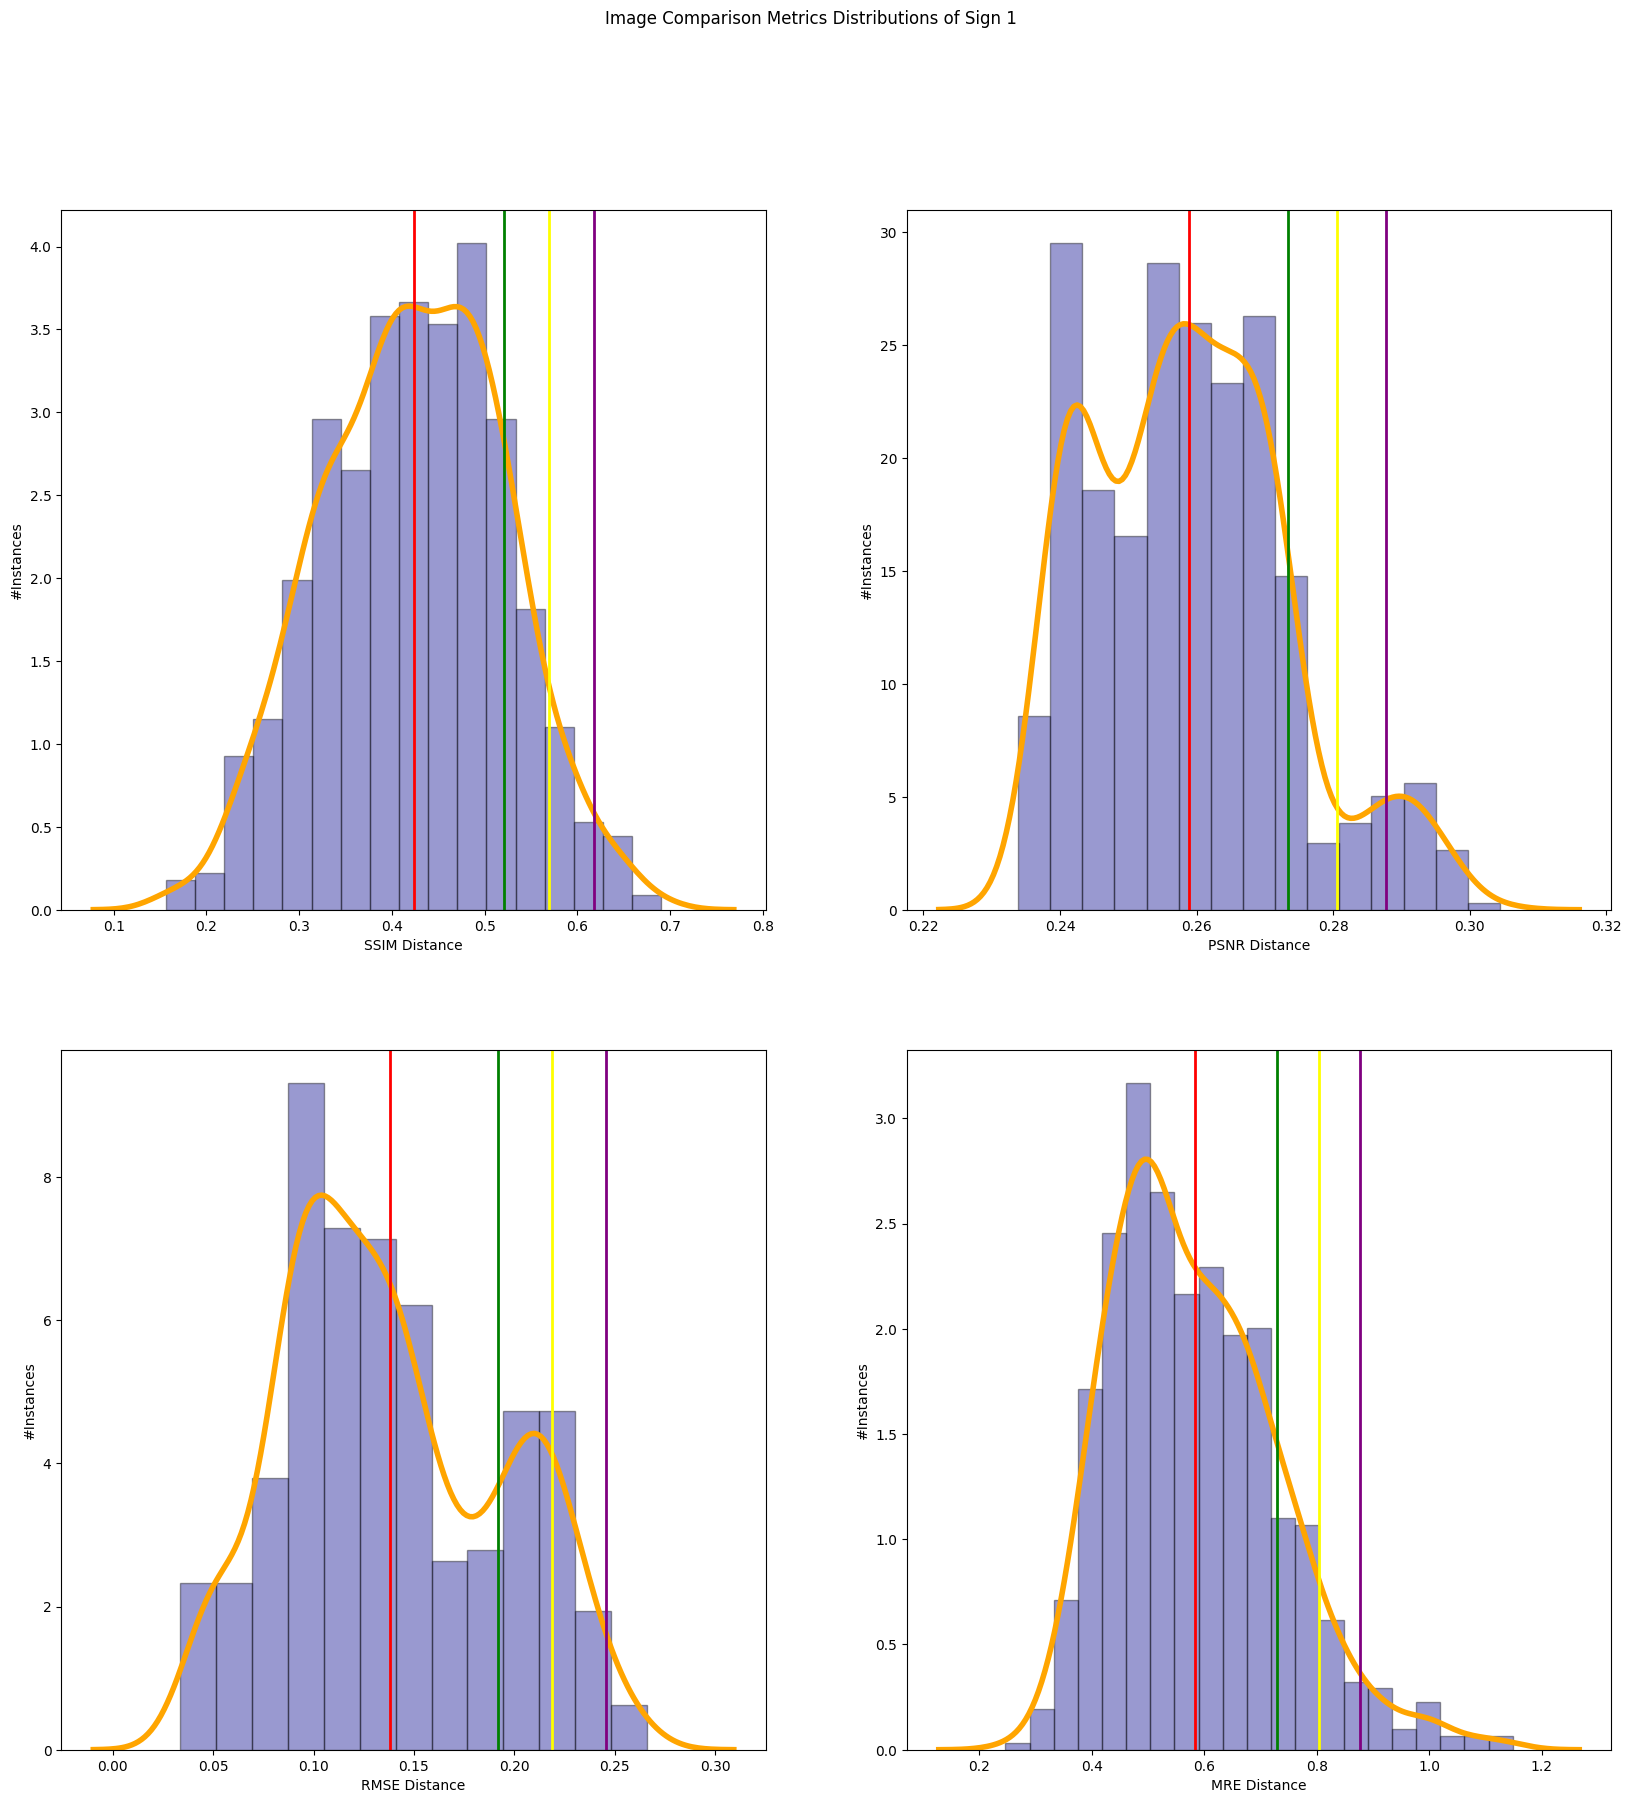

In [4]:
ssim1, psnr1, rmse1, mre1 = testset(test_path1, model_cropped_all)
visualize(ssim1, psnr1, rmse1, mre1, "1")
# _,_,_,_ = testset(test_path1_dmg, model_cropped_all,True)


15/15 [==============================] - 0s 4ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.386151052514712  ssim σ:  0.09970742365535058  ssim μ+σ:  0.48585847617006256
ssim μ+1.5σ:  0.5357121879977379  ssim μ+2σ:  0.5855658998254132
psnr mean:  0.27485287666320796  psnr σ:  0.019151654581741413  psnr μ+σ:  0.29400453124494935
psnr μ+1.5σ:  0.3035803585358201  psnr μ+2σ:  0.3131561858266908
rmse mean:  0.09181966  rmse σ:  0.04558673  rmse μ+σ:  0.1374064
rmse μ+1.5σ:  0.1601997558027506  rmse μ+2σ:  0.18299312144517899
mre mean:  0.5250822  mre σ:  0.14797623  mre μ+σ:  0.6730584
mre μ+1.5σ:  0.747046522796154  mre μ+2σ:  0.8210346400737762


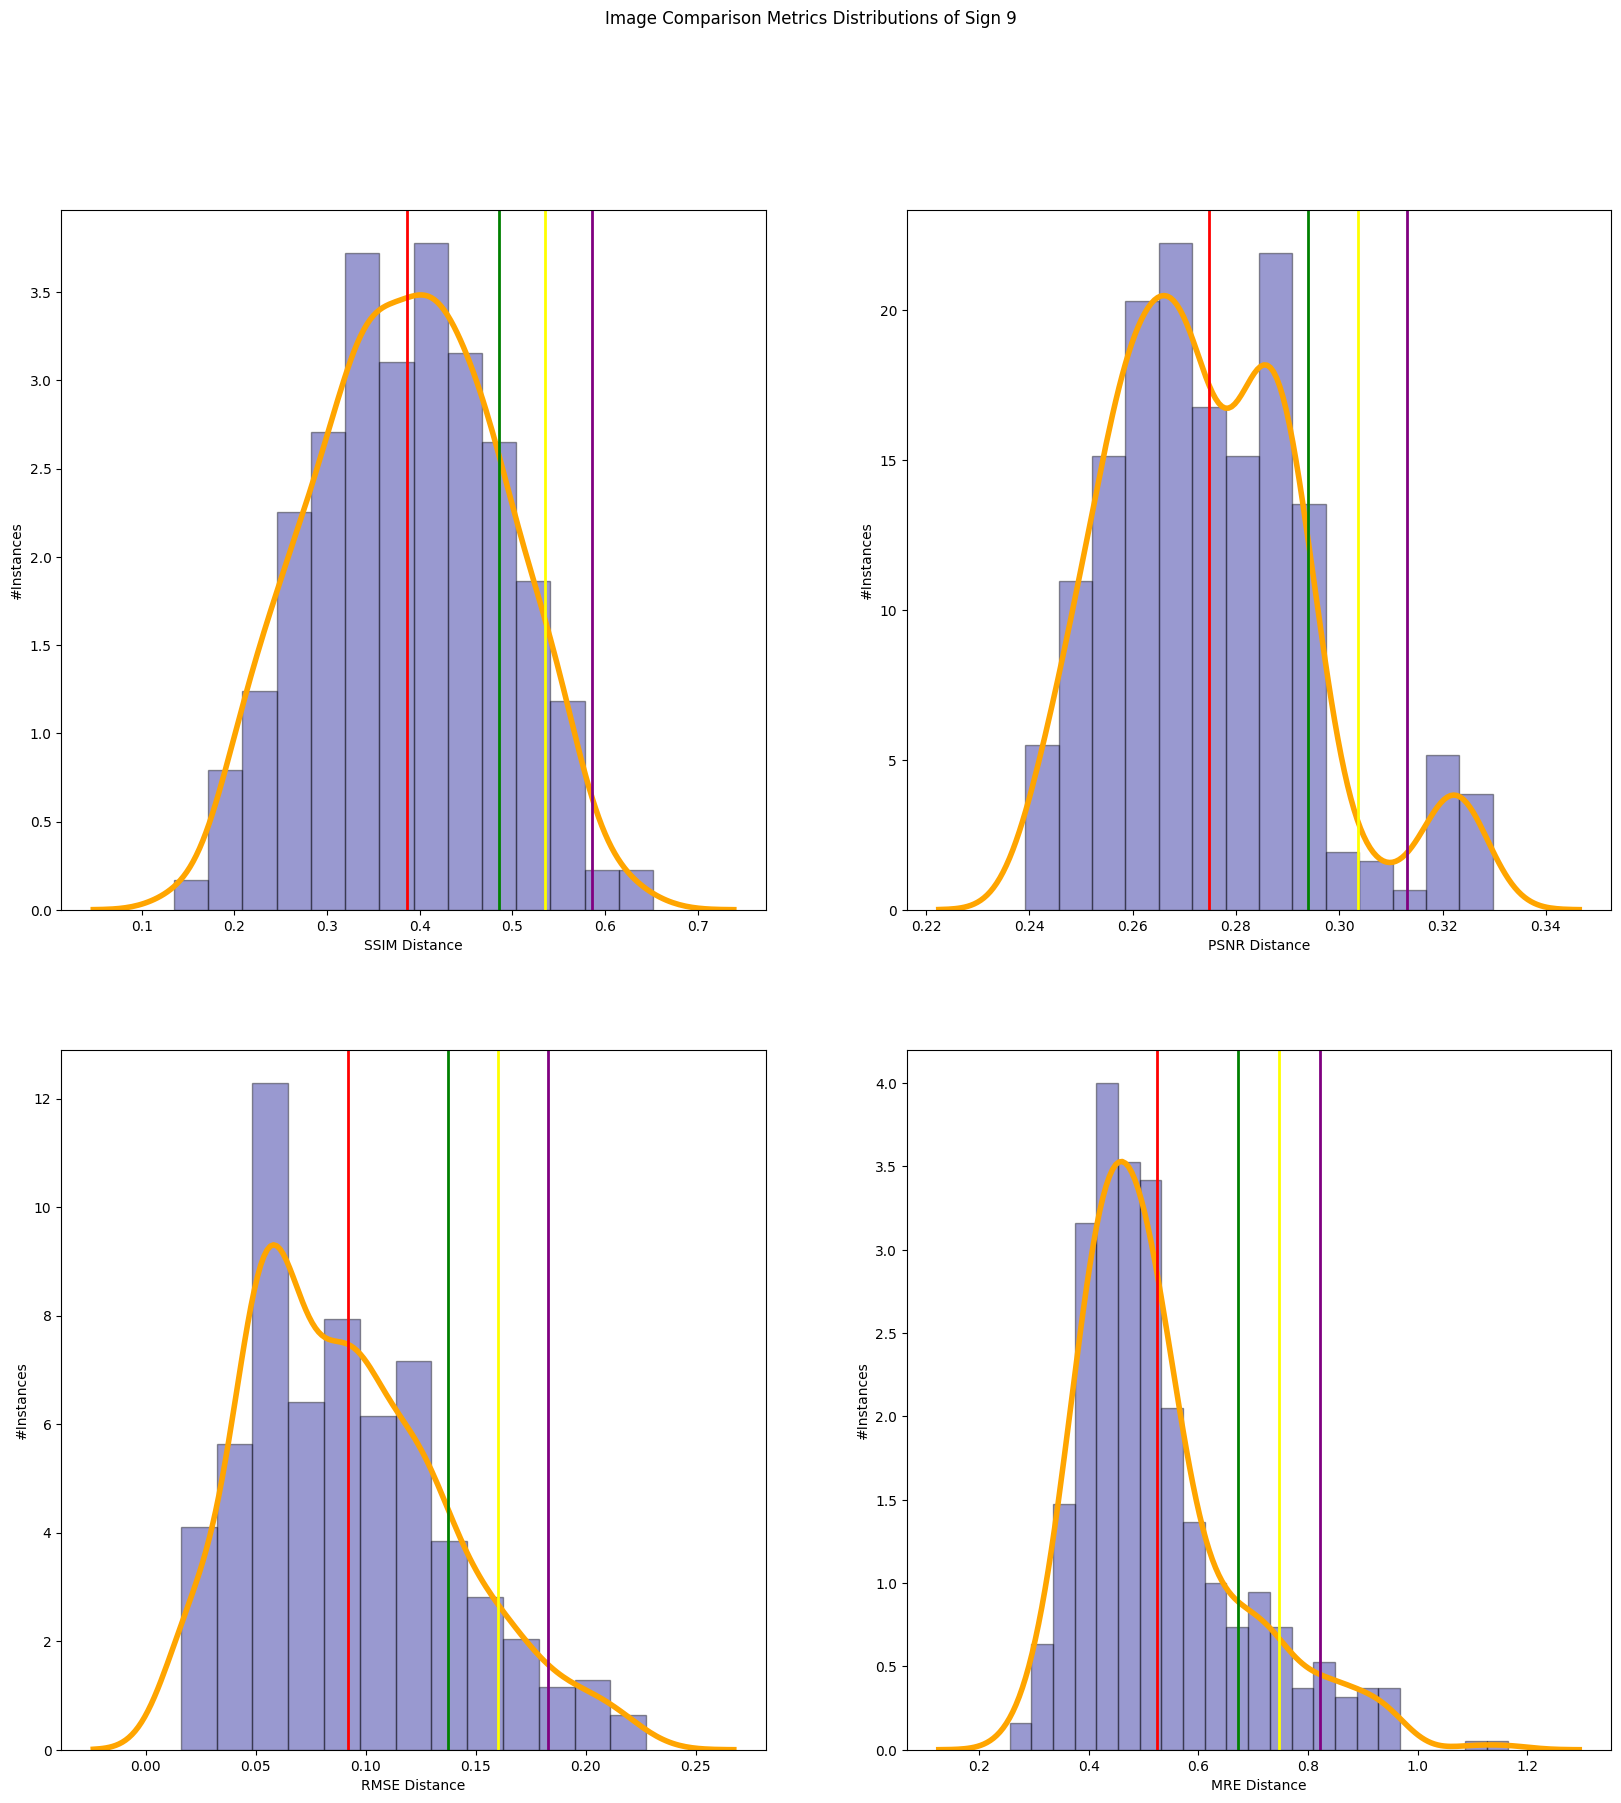

In [5]:
ssim9, psnr9, rmse9, mre9 = testset(test_path9, model_cropped_all)
visualize(ssim9, psnr9, rmse9, mre9,"9")
# _,_,_,_ = testset(test_path9_dmg, model_cropped_all,True)

9/9 [==============================] - 0s 10ms/step
#Instances:  270
Destructor called, Employee deleted.
ssim mean:  0.4329231917858124  ssim σ:  0.10584615245509839  ssim μ+σ:  0.5387693442409108
ssim μ+1.5σ:  0.5916924204684599  ssim μ+2σ:  0.6446154966960091
psnr mean:  0.2662660863872187  psnr σ:  0.015571372964623588  psnr μ+σ:  0.2818374593518423
psnr μ+1.5σ:  0.2896231458341541  psnr μ+2σ:  0.29740883231646587
rmse mean:  0.11258237  rmse σ:  0.044444237  rmse μ+σ:  0.1570266
rmse μ+1.5σ:  0.1792487259954214  rmse μ+2σ:  0.20147084444761276
mre mean:  0.5762847  mre σ:  0.1269775  mre μ+σ:  0.7032622
mre μ+1.5σ:  0.7667509615421295  mre μ+2σ:  0.8302397131919861


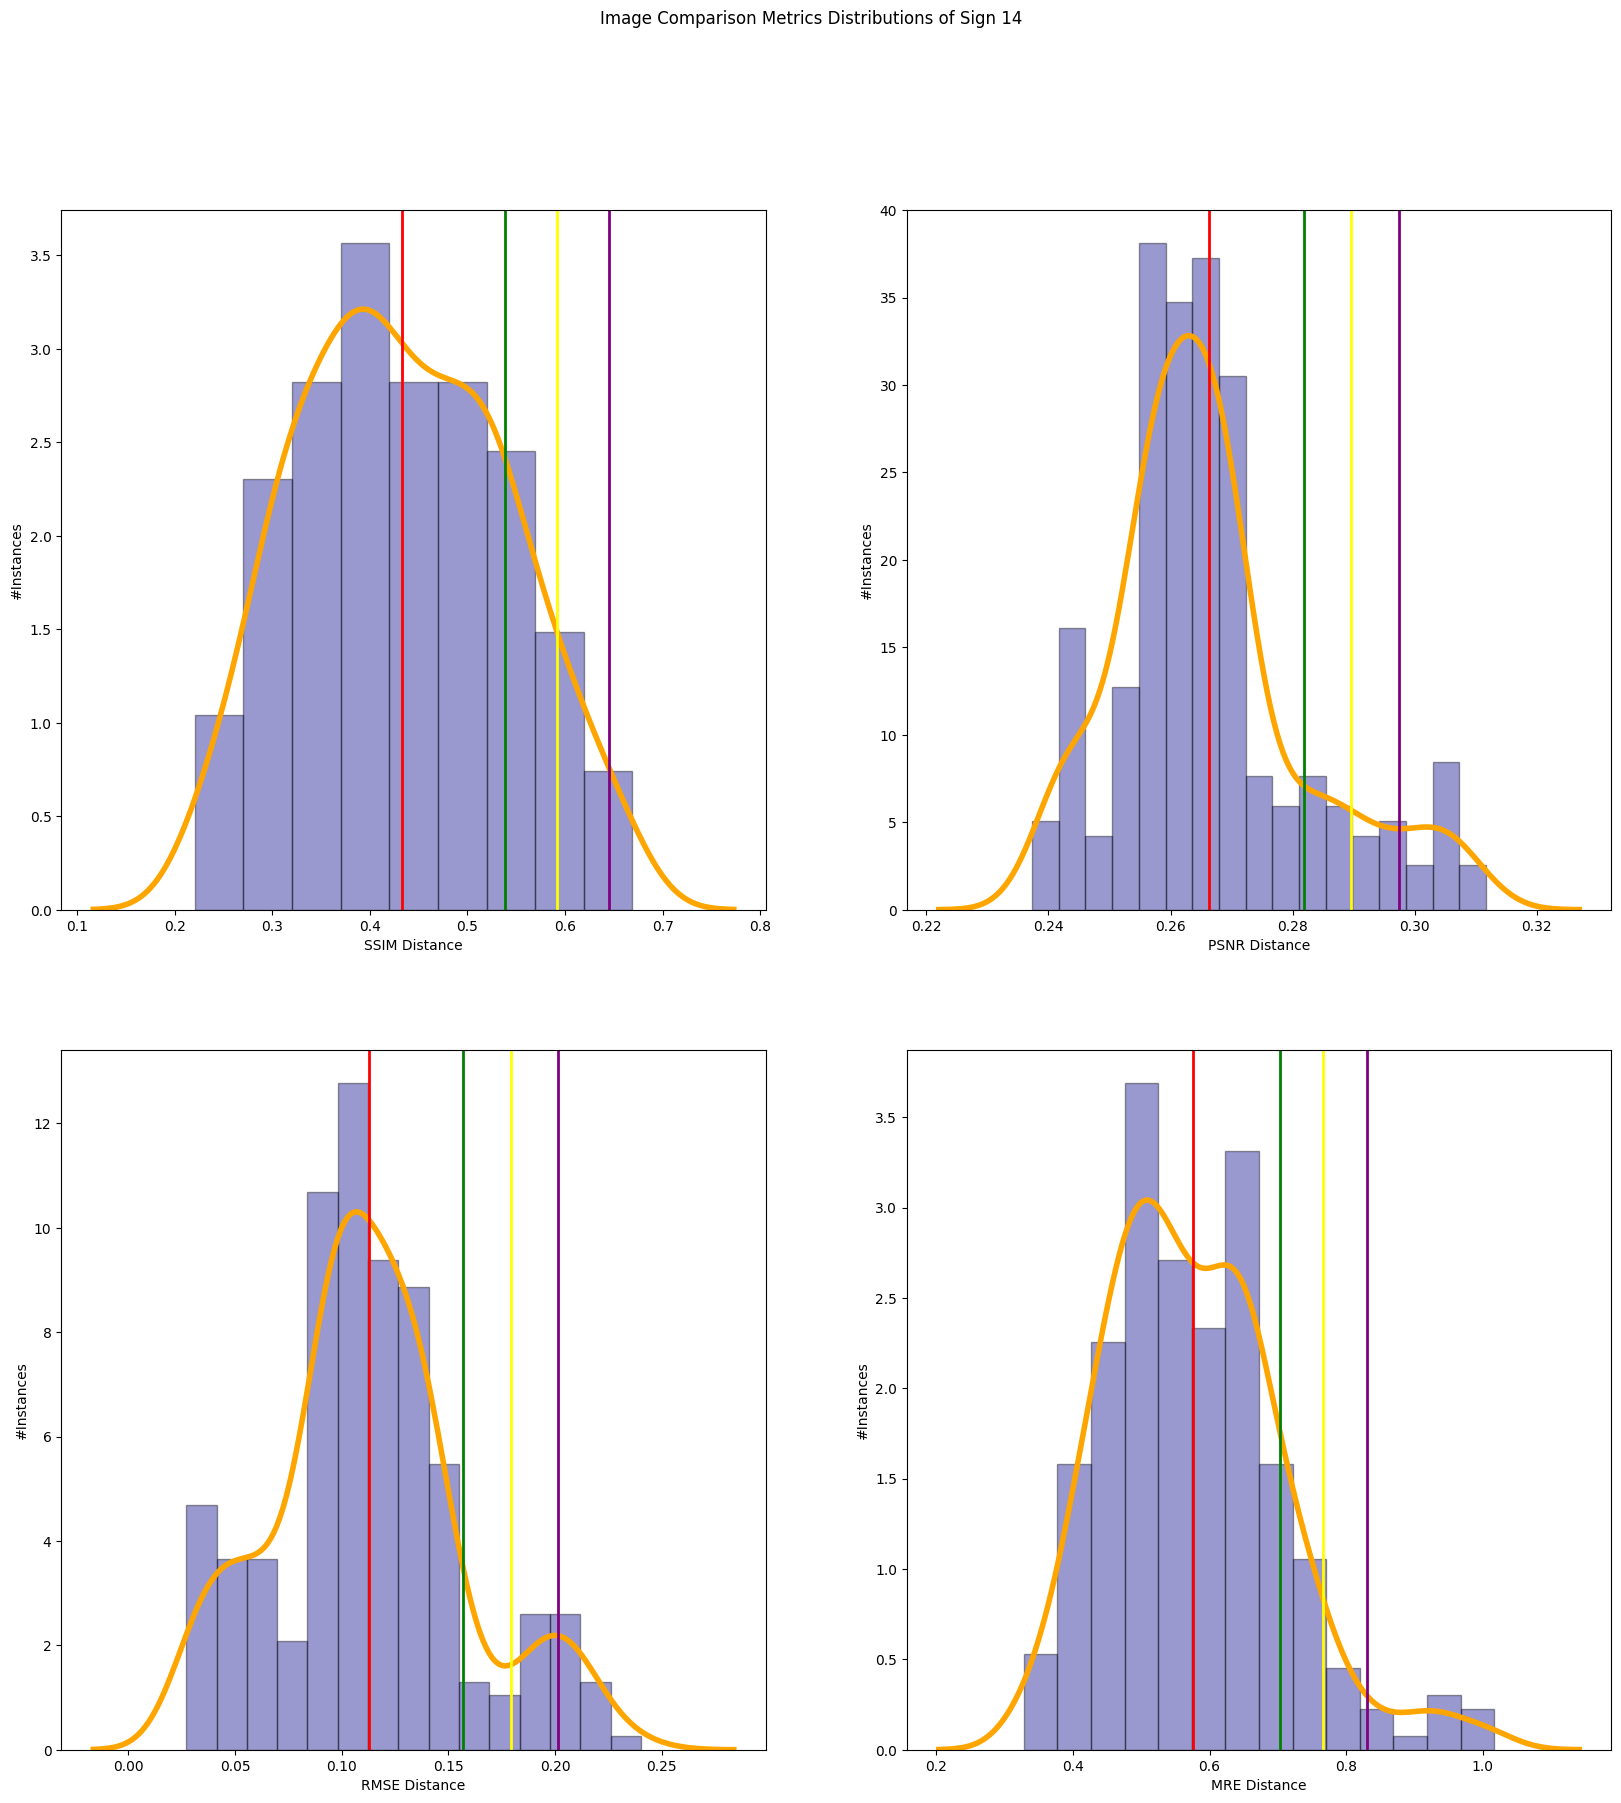

In [6]:
ssim14, psnr14, rmse14, mre14 = testset(test_path14, model_cropped_all)
visualize(ssim14, psnr14, rmse14, mre14,"14")
# _,_,_,_ = testset(test_path14_dmg, model_cropped_all,True)

12/12 [==============================] - 0s 8ms/step
#Instances:  360
Destructor called, Employee deleted.
ssim mean:  0.5017794597480032  ssim σ:  0.08651395341065134  ssim μ+σ:  0.5882934131586546
ssim μ+1.5σ:  0.6315503898639803  ssim μ+2σ:  0.6748073665693058
psnr mean:  0.25553982063576025  psnr σ:  0.012315280471220378  psnr μ+σ:  0.26785510110698063
psnr μ+1.5σ:  0.2740127413425908  psnr μ+2σ:  0.280170381578201
rmse mean:  0.14944723  rmse σ:  0.047977027  rmse μ+σ:  0.19742426
rmse μ+1.5σ:  0.22141277231276035  rmse μ+2σ:  0.2454012855887413
mre mean:  0.6076811  mre σ:  0.181356  mre μ+σ:  0.7890371
mre μ+1.5σ:  0.8797150924801826  mre μ+2σ:  0.9703930914402008


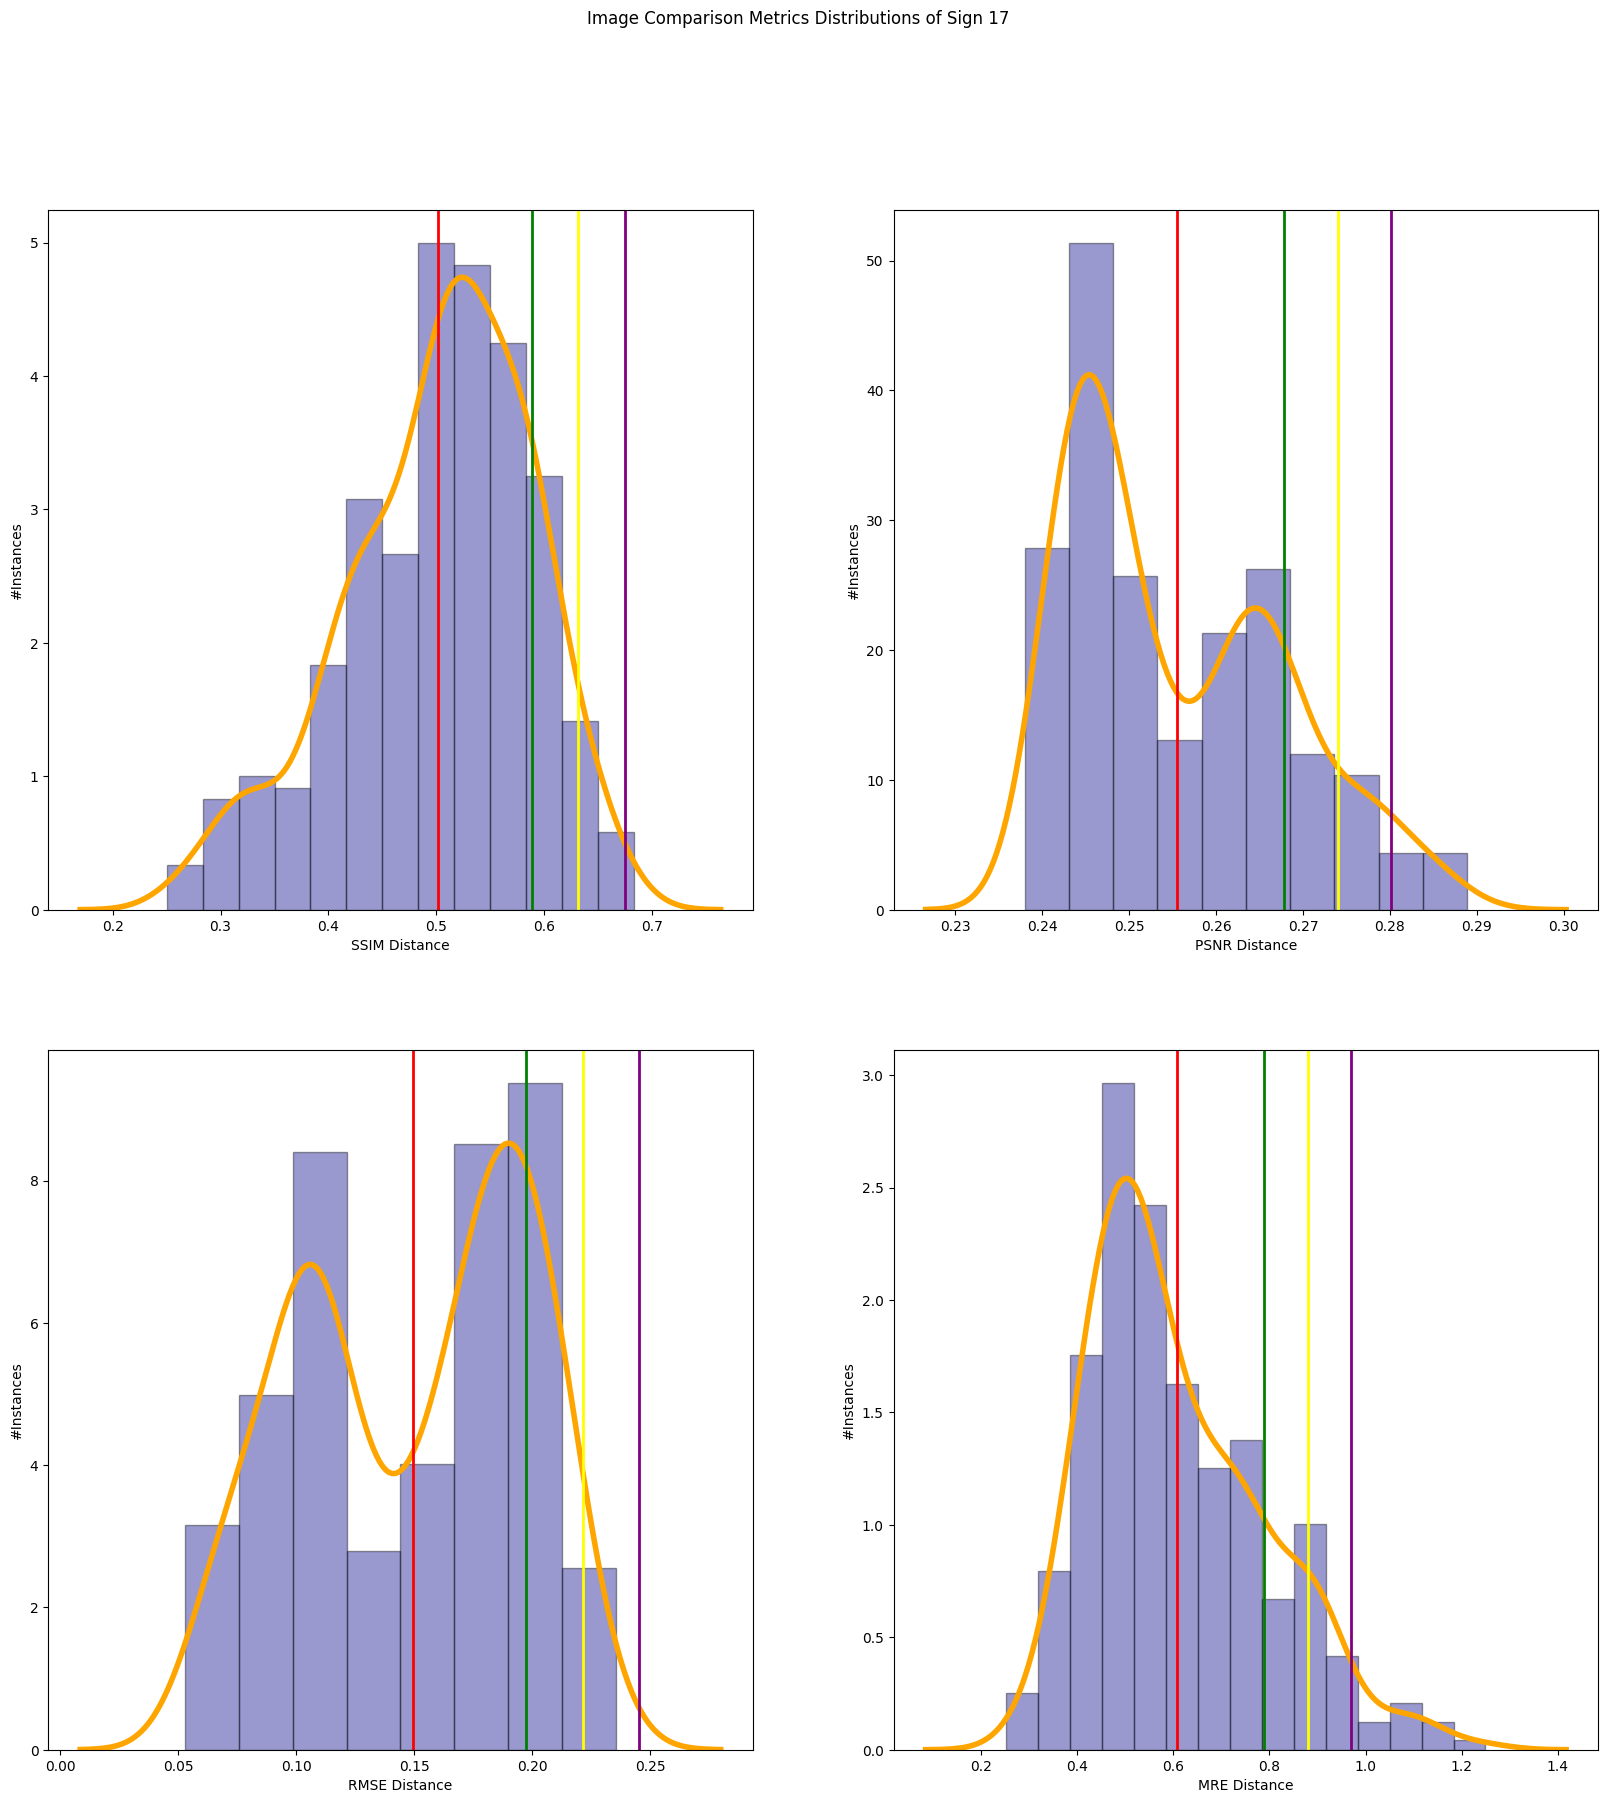

In [7]:
ssim17, psnr17, rmse17, mre17 = testset(test_path17, model_cropped_all)
visualize(ssim17, psnr17, rmse17, mre17,"17")
# _,_,_,_ = testset(test_path17_dmg, model_cropped_all,True)

15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.4541732881218195  ssim σ:  0.100968646361615  ssim μ+σ:  0.5551419344834345
ssim μ+1.5σ:  0.6056262576642419  ssim μ+2σ:  0.6561105808450495
psnr mean:  0.25954575142829245  psnr σ:  0.015756553053879036  psnr μ+σ:  0.27530230448217147
psnr μ+1.5σ:  0.28318058100911103  psnr μ+2σ:  0.29105885753605054
rmse mean:  0.13645983  rmse σ:  0.048323046  rmse μ+σ:  0.18478288
rmse μ+1.5σ:  0.20894439704716206  rmse μ+2σ:  0.23310592025518417
mre mean:  0.61610144  mre σ:  0.15893085  mre μ+σ:  0.7750323
mre μ+1.5σ:  0.8544977232813835  mre μ+2σ:  0.9339631497859955


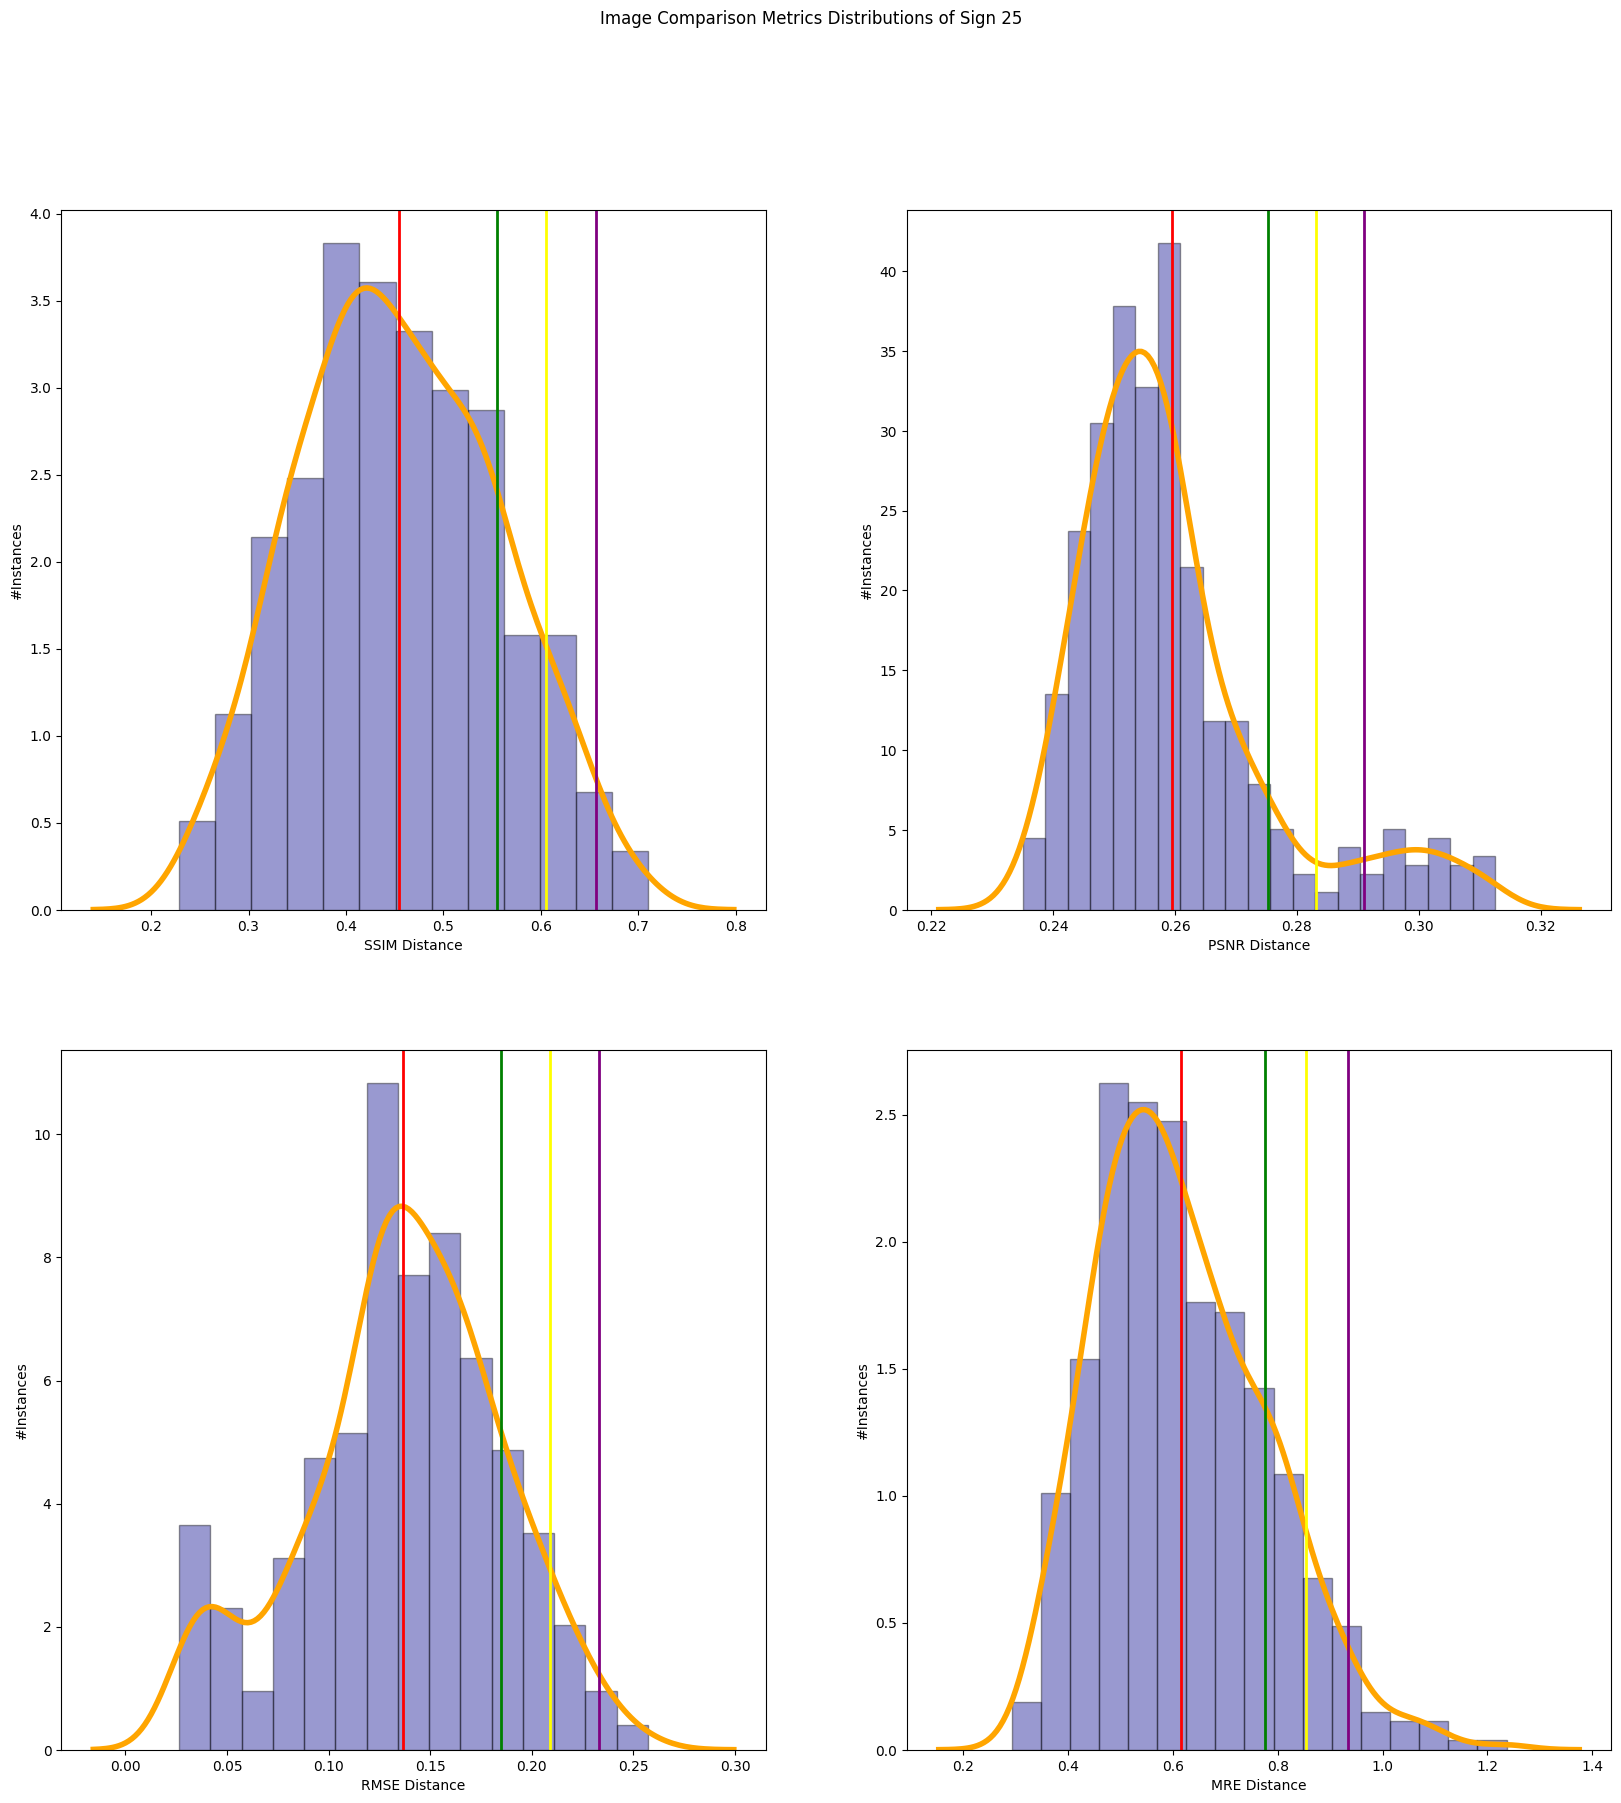

In [8]:
ssim25, psnr25, rmse25, mre25 = testset(test_path25, model_cropped_all)
visualize(ssim25, psnr25, rmse25, mre25,"25")
# _,_,_,_ = testset(test_path25_dmg, model_cropped_all,True)

3/3 [==============================] - 0s 31ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.4283507731225755  ssim σ:  0.1171628396546056  ssim μ+σ:  0.5455136127771811
ssim μ+1.5σ:  0.6040950326044839  ssim μ+2σ:  0.6626764524317867
psnr mean:  0.26576064897258816  psnr σ:  0.03081302807724212  psnr μ+σ:  0.2965736770498303
psnr μ+1.5σ:  0.3119801910884513  psnr μ+2σ:  0.3273867051270724
rmse mean:  0.1413555  rmse σ:  0.0803246  rmse μ+σ:  0.2216801
rmse μ+1.5σ:  0.26184239611029625  rmse μ+2σ:  0.30200469493865967
mre mean:  0.5979854  mre σ:  0.19665109  mre μ+σ:  0.7946365
mre μ+1.5σ:  0.8929620161652565  mre μ+2σ:  0.9912875592708588


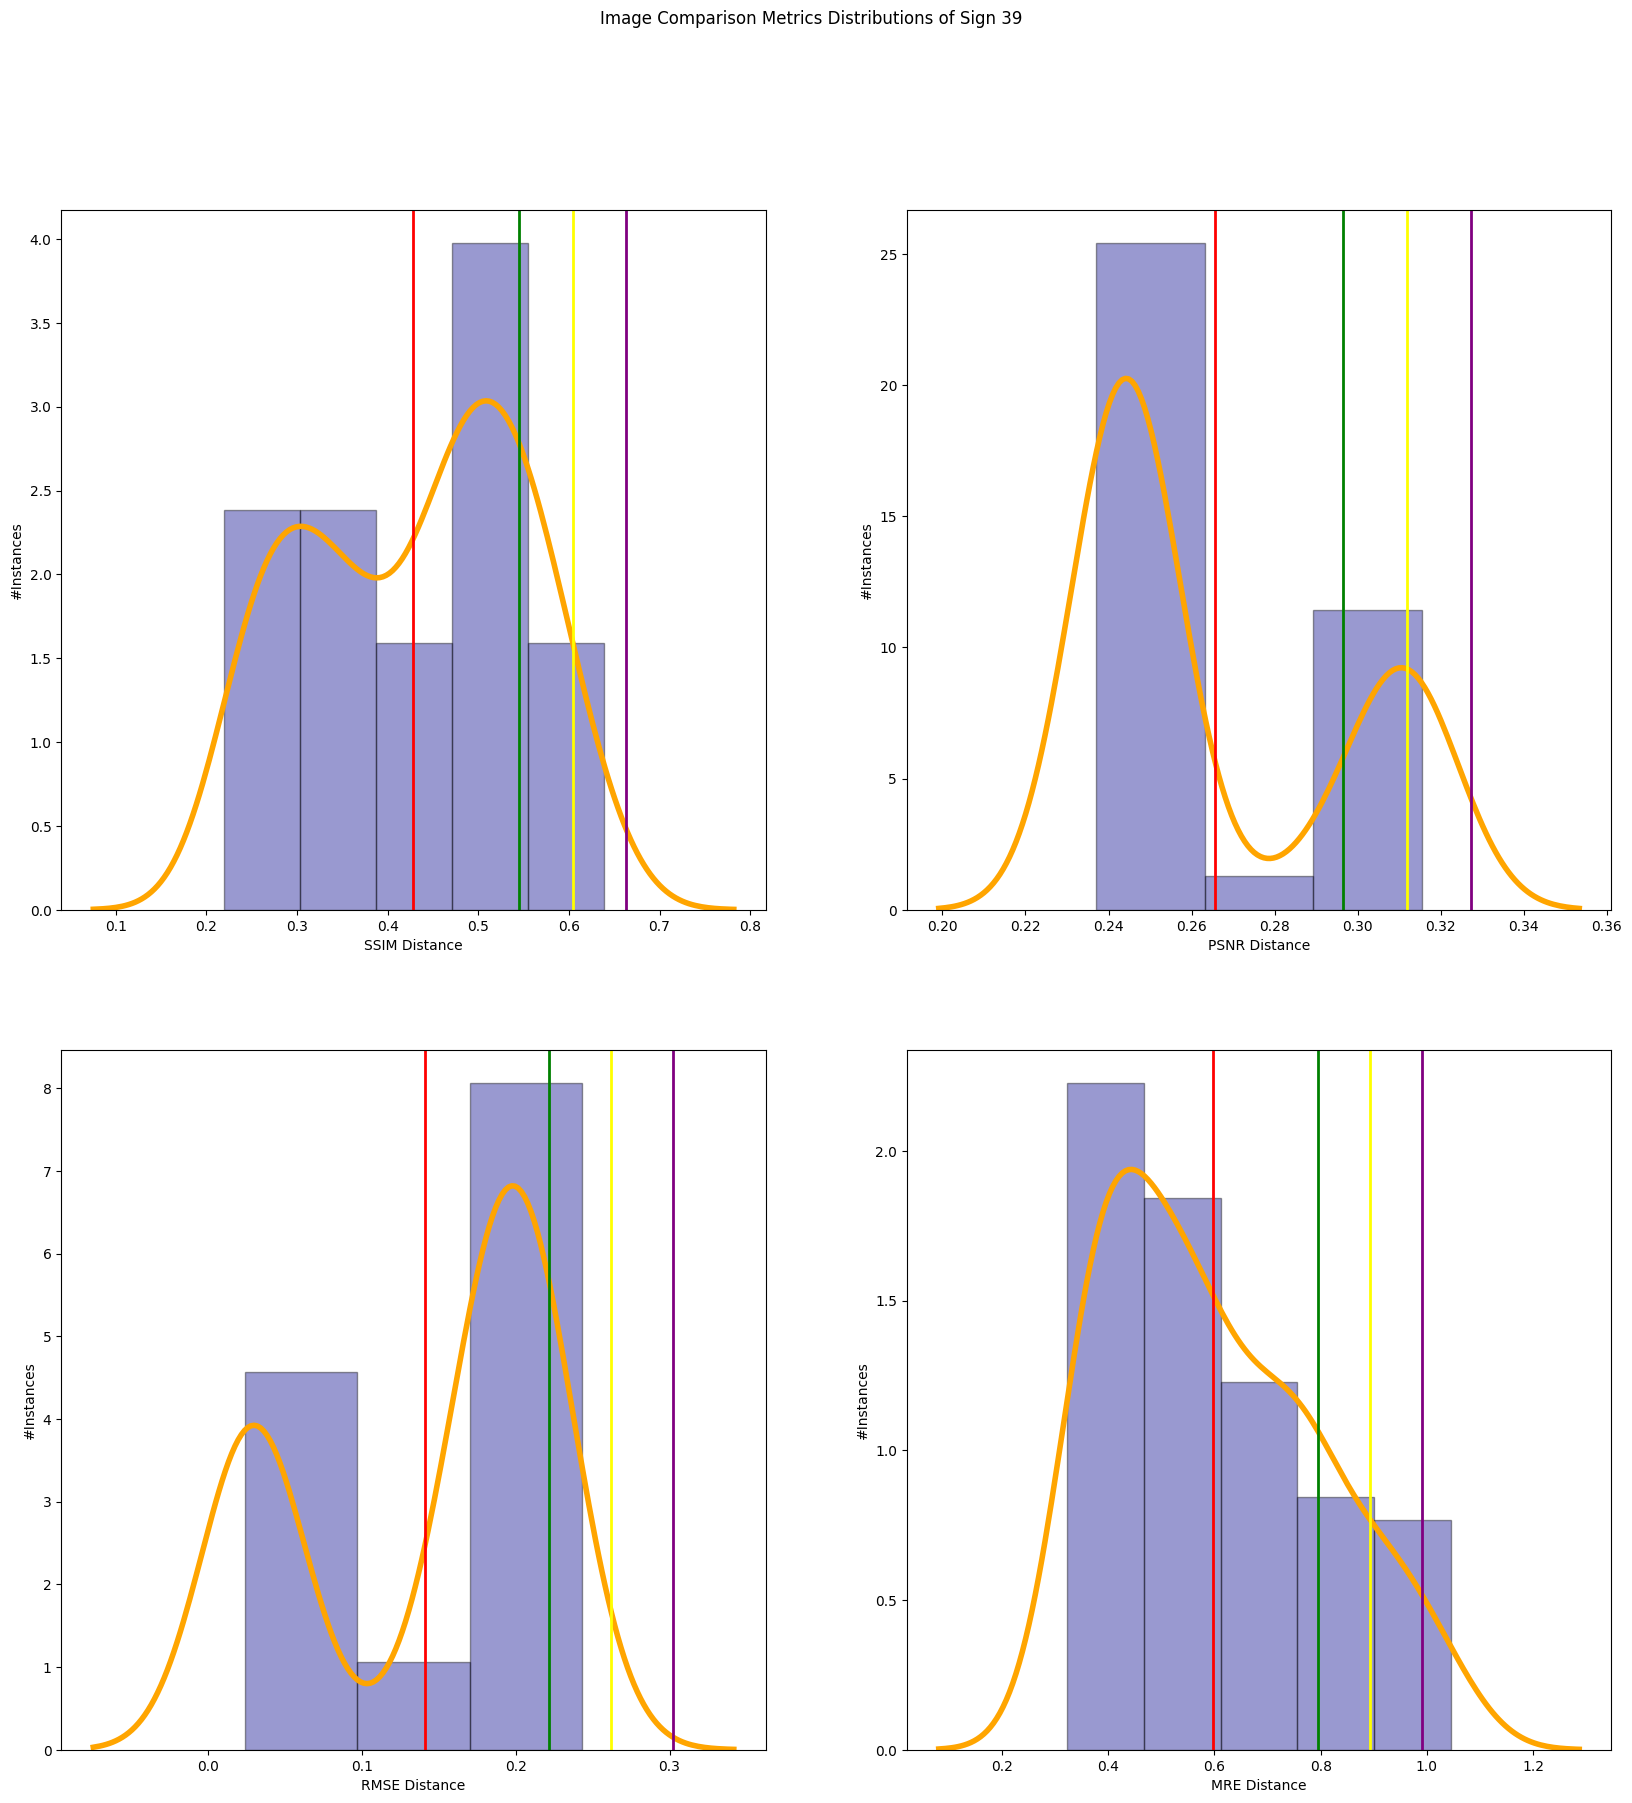

: 

In [9]:
ssim39, psnr39, rmse39, mre39 = testset(test_path39, model_cropped_all)
visualize(ssim39, psnr39, rmse39, mre39,"39")
# _,_,_,_ = testset(test_path39_dmg, model_cropped_all,True)